## steps to deploy tensorflow model using tensorflow serving

1. load library/ dependencies
2. create the model
3. save the model --> format must be like, folder name must be integer number like 0, 1, 2.... this interger number folder defines the version number of the model
and based on version number tensorflow serving choose the model to serve the response
save the model using , >>

tf.keras.models.save_model(

model_object,
absolute_path_of the model,

overwrite = True is you want to overwrite else false, (keep true),

include_optimizer  = True >>>> where, Optimizers are the extended class, which include added information to train a specific model 

save_format = None ...>>Either 'tf' or 'h5', indicating whether to save the model to Tensorflow SavedModel or HDF5. Defaults to 'tf' in TF 2.X, and 'h5' in TF 1.X.

options =  None ...>>Optional tf.saved_model.SaveOptions object that specifies options for saving to SavedModel.
)

4. Add TensorFlow Serving distribution URI as a package source

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

  5. install tensorflow-model-server
  6.Start running tensorflow server by defining modelname, port number, and path of the model
  os.environ["MODEL_DIR"] = MODEL_DIR

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

  7. check wether server is on or not

!tail server.log

  8.create json api for prediciton

import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})


import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data1, headers=headers)
predictions = json.loads(json_response.text)['predictions']

  9. create show funstion to show the predicted and actual output

def show1(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(x_test)-1)
show(rando, 'An Example Image: {}'.format(class_names[y_test[rando]]))


for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))

    

tensorflow serving uses higher version number as a default model for serving, but if you want to serve specific version instead of higher version you can specify in the url --> versions/version_number

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
(x_train, y_train),(x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28*28)/255.0
x_test = x_test.reshape(-1, 28*28) /255.0

model1 = Sequential()
model1.add(Dense(512, input_shape = (784,), activation='relu'))
model1.add(Dense(10, activation='softmax'))

model1.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

model1.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test))

loss, acc = model1.evaluate(x_test, y_test, verbose = 2)

print('model accuarcy={:5.2f}'.format(acc*100))



Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2014 - accuracy: 0.9410 - val_loss: 0.0915 - val_accuracy: 0.9706
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0808 - accuracy: 0.9755 - val_loss: 0.0746 - val_accuracy: 0.9768
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0516 - accuracy: 0.9841 - val_loss: 0.0612 - val_accuracy: 0.9817
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0367 - accuracy: 0.9883 - val_loss: 0.0720 - val_accuracy: 0.9791
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0278 - accuracy: 0.9912 - val_loss: 0.0640 - val_accuracy: 0.9821
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0610 - val_accuracy: 0.9813
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0169 - accuracy: 0.9942 - val_loss: 0.0687 - val_accuracy:

In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

# MODEL_DIR = tempfile.gettempdir()
MODEL_DIR = '/home'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model1,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /home/1

INFO:tensorflow:Assets written to: /home/1/assets

Saved model:
total 76
drwxr-xr-x 2 root root  4096 Sep 11 08:44 assets
-rw-r--r-- 1 root root 67211 Sep 11 08:44 saved_model.pb
drwxr-xr-x 2 root root  4096 Sep 11 08:44 variables


In [ ]:
# creating and saving model2
# here i am creating same model for model2 and model1, just changing its object name

model2 = Sequential()
model2.add(Dense(512, input_shape= (784,), activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics= ['accuracy'])

model2.fit(x_train, y_train, validation_data = (x_test, y_test),epochs = 10)

# saving the model2
version = 2
export_path2 = os.path.join(MODEL_DIR,str(version) )

tf.keras.models.save_model(
    model2,
    export_path2,
    overwrite = True,
    include_optimizer = True,
    save_format = None,
    signatures = None,
    options = None

)

!ls -l {export_path2}

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2038 - accuracy: 0.9406 - val_loss: 0.1013 - val_accuracy: 0.9682
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0818 - accuracy: 0.9760 - val_loss: 0.0758 - val_accuracy: 0.9753
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0510 - accuracy: 0.9841 - val_loss: 0.0664 - val_accuracy: 0.9790
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0378 - accuracy: 0.9878 - val_loss: 0.0732 - val_accuracy: 0.9772
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.0852 - val_accuracy: 0.9747
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 0.0715 - val_accuracy: 0.9793
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.0617 - val_accuracy:

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubu

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.3.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 77 not upgraded.


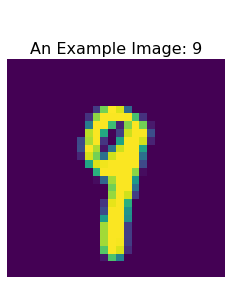

In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(x_test)-1)
show(rando, 'An Example Image: {}'.format(class_names[y_test[rando]]))

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=single_multi_versions \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 2 in a separate thread.


In [ ]:
import json
data1 = json.dumps({"signature_name": "serving_default", "instances": x_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}


<Response [200]>


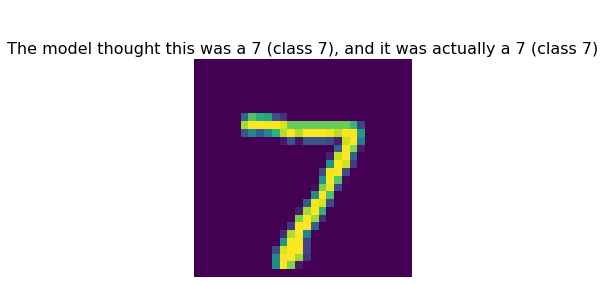

In [ ]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/single_multi_versions:predict', data=data1, headers=headers)
predictions = json.loads(json_response.text)['predictions']
# print(json.loads(json_response.text))

print(json_response)
show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[y_test[0]], y_test[0]))